In [1]:
# Clear all variables
%reset -f

# import libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [116]:
# read the CSV file into a DataFrame
csv_data = pd.read_csv("data/data.csv")

#inspect the data
display(csv_data.tail(5))

,Date,Time,Mood_Level_(1-10),Energy_Level_(1-10),Stress_Level_(1-10),Activities,Hours_of_Sleep,Location,Weather,Temperature_°C
25,15/11/2024,13:49,6,7,3,NaN,12.0,"Dublin, IE",broken clouds,12.62
26,14/11/2024,22:22,7,2,2,rugby,6.0,"Dublin, IE",broken clouds,6.34
27,17/11/2024,17:04,5,4,4,NaN,8.0,"Dublin, IE",light intensity drizzle rain,8.69
28,17/11/2024,22:11,6,6,3,NaN,NaN,"Dublin, IE",light intensity drizzle rain,7.96
29,2024-11-18,11:26,6,4,3,walk gym,6.0,"Dublin, IE",light rain,6.60


In [117]:
# cleaning the data
# =================
data = csv_data

# clean the column entries
# ------------------------

# sort alphabetically 
data['Activities'] = data['Activities'].dropna().apply(lambda x: ' '.join(sorted(x.split())))

data['Activities'] = (
    data['Activities']
    .fillna('none')  # replace blank entries with "none"
    .str.strip()  # remove leading and trailing spaces
    .str.lower()  # make all lowercase
    .str.replace(' ', '_', regex=True)  # replace spaces with underscores
)



# clean the weather column
data['Weather'] = (
                    data['Weather']
                    .str.strip() # remove leading and trailing spaces
                    .str.lower() # make all lower case
                    .str.replace(' ', '_', regex=True) # remove spaces
)


# clean the location column
data['Location'] = (data['Location'].fillna('Unknown') # replace blank entries with "none"
)



# fix Na entries
# --------------

# sleep data - take previous entry for that day
data['Hours_of_Sleep'] = (data.
                          groupby('Date')['Hours_of_Sleep']. # group the sleep data by day
                          transform(lambda x: x 
                                    .fillna(method='ffill') # ffill the NA's
                                    .fillna(method='bfill'))) # back fill if available





# columns to fill NA values
columns_to_fill = ['Mood_Level_(1-10)',
                   'Energy_Level_(1-10)',
                   'Stress_Level_(1-10)',
                   'Hours_of_Sleep',
                   'Temperature_°C']

# apply rolling mean fill for each specified column
data[columns_to_fill] = data[columns_to_fill].apply(lambda x: x.fillna(x.rolling(window=5, min_periods=1).mean()))





# dummy columns
# -------------

# Add dummy columns for activities and weather
data = pd.get_dummies(data, columns=["Activities"], prefix="Activity")
data = pd.get_dummies(data, columns=["Weather"], prefix="Weather")


# MISC formatting 
# ---------------

# ensure date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True).dt.strftime('%Y-%m-%d')


# rename columns
data.rename(columns={'Date': 'date', 
                     'Time': 'time',
                     'Mood_Level_(1-10)':'mood',
                     'Energy_Level_(1-10)' : 'energy',
                     'Stress_Level_(1-10)' : 'stress',
                     'Hours_of_Sleep' : 'sleep',
                     'Location': 'location',
                     'Temperature_°C' : 'temp',
                     'Activity_none' : 'no_activity',
                     'Activity_rugby_walk': 'rugby_and_walk',
                     'Activity_walk' : 'walk',
                     'Activity_gym_walk' : 'walk_and_gym',
                     'Weather_broken_clouds':'broken_clouds',
                     'Weather_light_intensity_drizzle':'light_intensity_drizzle',
                     'Weather_overcast_clouds': 'overcast_clouds',
                     'Weather_clear_sky': 'clear_sky'}, inplace=True)


display(data.tail(5))

,date,time,mood,energy,stress,sleep,location,temp,walk_and_gym,no_activity,...,rugby_and_walk,walk,broken_clouds,clear_sky,Weather_few_clouds,Weather_fog,light_intensity_drizzle,Weather_light_intensity_drizzle_rain,Weather_light_rain,overcast_clouds
25,2024-11-15,13:49,6,7,3,12.0,"Dublin, IE",12.62,0,1,...,0,0,1,0,0,0,0,0,0,0
26,2024-11-14,22:22,7,2,2,6.0,"Dublin, IE",6.34,0,0,...,0,0,1,0,0,0,0,0,0,0
27,2024-11-17,17:04,5,4,4,8.0,"Dublin, IE",8.69,0,1,...,0,0,0,0,0,0,0,1,0,0
28,2024-11-17,22:11,6,6,3,8.0,"Dublin, IE",7.96,0,1,...,0,0,0,0,0,0,0,1,0,0
29,2024-11-18,11:26,6,4,3,6.0,"Dublin, IE",6.60,1,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
def make_bool(df, columns):

    # check if all specified columns exist in the DataFrame
    missing_cols = set(columns) - set(df.columns)
    
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {missing_cols}")
    
    # convert specified columns: any non-zero value becomes 1, else 0
    df[columns] = (df[columns] != 0).astype(int)
    
    return df







cols_to_exclude = ['date', 'time', 'mood', 'energy', 'stress', 'sleep',
                   'location','temp']

cols_to_group = data.columns[~data.columns.isin(cols_to_exclude)]
cols_to_group


grouped_data = data.groupby('date').mean().round(1)


make_bool(grouped_data,cols_to_group)


,mood,energy,stress,sleep,temp,walk_and_gym,no_activity,Activity_rugby,rugby_and_walk,walk,broken_clouds,clear_sky,Weather_few_clouds,Weather_fog,light_intensity_drizzle,overcast_clouds
date,,,,,,,,,,,,,,,,
2024-11-01,6.0,3.0,4.0,8.0,12.0,0,0,0,0,1,0,0,0,0,0,1
2024-11-02,7.0,8.0,2.0,8.5,11.7,0,1,0,0,0,0,0,0,0,1,0
2024-11-03,7.0,7.0,2.0,8.2,13.4,0,0,0,0,1,1,0,0,0,0,0
2024-11-04,7.7,5.7,2.3,7.0,12.0,1,0,0,0,0,1,0,0,0,0,0
2024-11-05,9.0,4.5,2.0,6.8,12.3,1,0,0,1,0,1,0,0,0,0,0
2024-11-06,8.5,8.0,2.5,8.0,15.7,0,1,0,0,1,1,0,0,0,0,0
2024-11-07,6.0,6.0,6.0,7.0,14.1,1,0,0,0,0,1,0,0,0,0,0
2024-11-08,7.0,6.0,3.5,6.2,12.5,0,1,0,0,1,1,0,0,0,1,0
2024-11-09,8.0,8.5,2.0,9.0,12.1,0,1,0,1,0,1,0,0,0,0,0


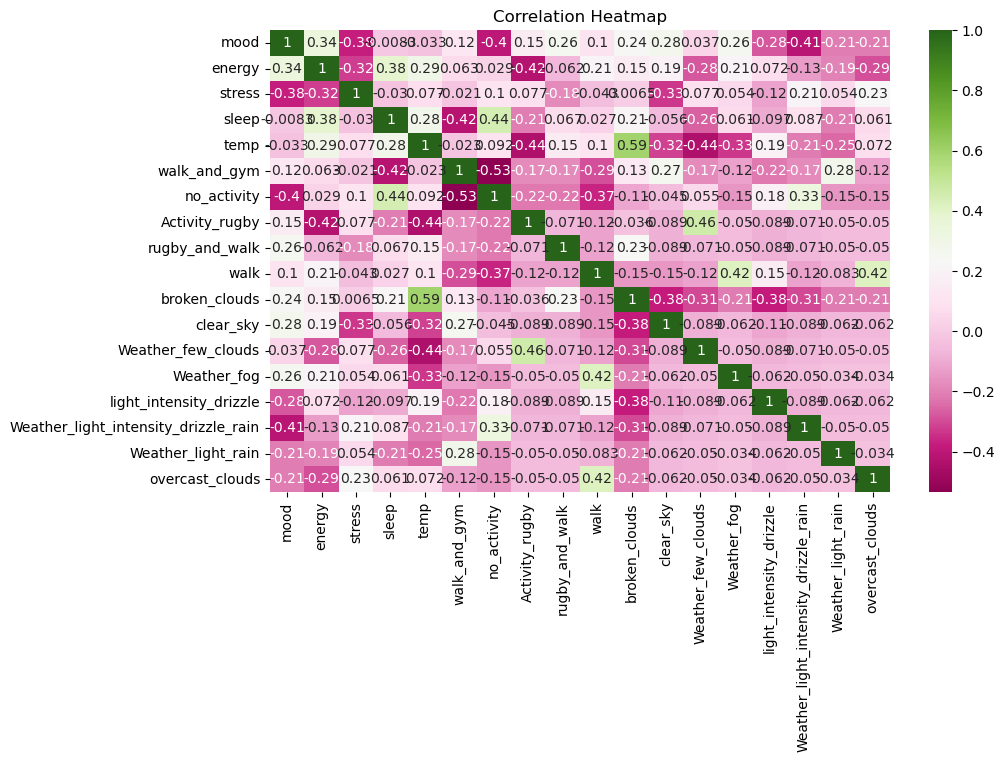

In [4]:
df = data    
    
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='PiYG')
plt.title('Correlation Heatmap')
plt.show()

In [5]:
## add section defs for <3 <5 <1



# calculate the correlation matrix
corr_matrix = df.corr().abs()  # using absolute values to check the strength, regardless of direction

# Define a threshold for "significant" correlations
threshold = 0.6

# Find pairs where the correlation is above the threshold, but exclude self-correlations (diagonal)
significant_corr = corr_matrix[(corr_matrix >= threshold) & (corr_matrix < 1.0)]

# Drop NaN values (non-significant pairs will be NaN after applying the threshold)
significant_corr = significant_corr.unstack().dropna().sort_values(ascending=False)

# Display the significant correlations
print(significant_corr)

Series([], dtype: float64)


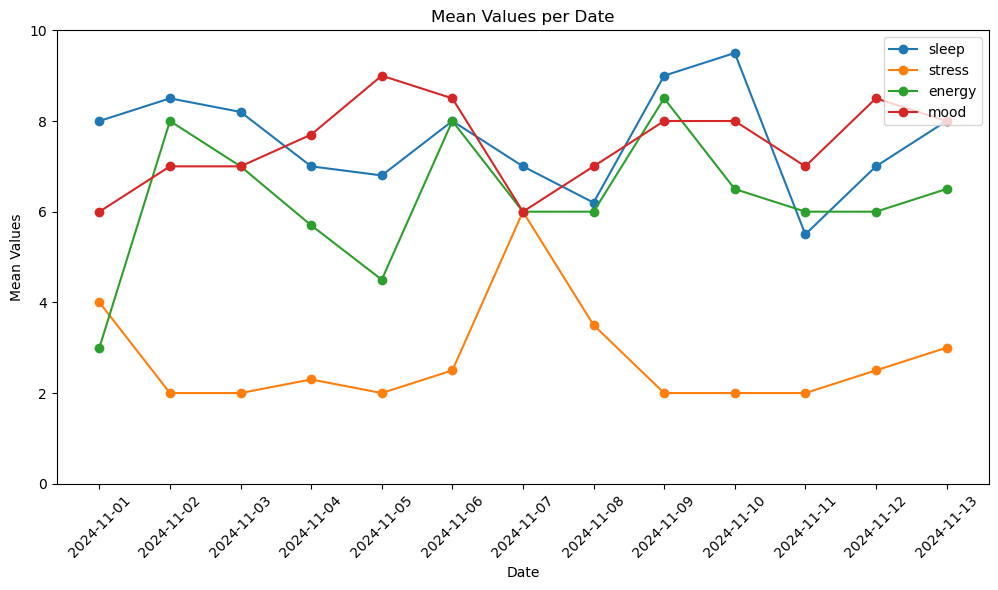

In [11]:
# Plotting
df = data
df = grouped_data    

variables = ['sleep','stress', 'energy', 'mood']

# Group by date and calculate the mean
daily_means = df[variables]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(daily_means.index, daily_means.values, marker='o')  # Line plot with markers
plt.xlabel('Date')
plt.ylabel('Mean Values')
plt.title('Mean Values per Date')
plt.xticks(rotation=45)
plt.legend(daily_means.columns, loc='upper right')
plt.tight_layout()
plt.ylim((0,10))

plt.show()

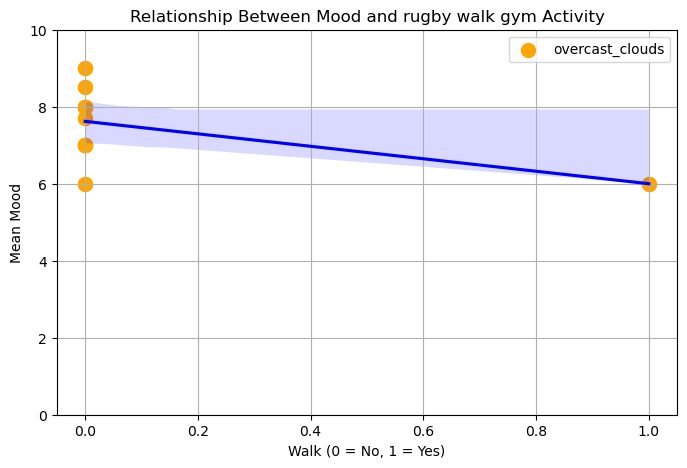

In [85]:
df = grouped_data

# Plotting
plt.figure(figsize=(8, 5))

# Scatter plot for mean_mood vs. _walk
plt.scatter(df['overcast_clouds'], df['mood'], color='orange', label='overcast_clouds', s=100)


sns.regplot(x=df['overcast_clouds'], y=df['mood'], scatter_kws={'color': 'orange', 's': 100}, line_kws={'color': 'blue'})

plt.ylim(0, 10)


# Adding labels and title
plt.xlabel('Walk (0 = No, 1 = Yes)')
plt.ylabel('Mean Mood')
plt.title('Relationship Between Mood and rugby walk gym Activity')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()



In [15]:
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime

# turn into a function!!!
# error if out of bounds...

city = 'Dublin'
year = 2024
month = 11 # 1-12
day = 10
hour = 10
minute = 15



# Define the location (you can modify this with your desired city's name)
city = LocationInfo(city)

# Define the date and time you want to check
input_date_time = datetime(year, month, day)#, hour, minute) 

# Calculate the sunrise and sunset times
s = sun(city.observer, date=input_date_time.date())

sunrise = s['sunset']
sunrise_hour = sunrise.hour
sunrise_minute = sunrise.minute


sunrise =f'{sunrise.hour}:{sunrise_minute:02d}'

type(sunrise)

sunrise




#data['time'] < sunrise


'16:16'

In [114]:
import pandas as pd
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime

# Define the function to calculate daylight for each row
def get_daylight(row):
    city_name = row['location'].split(',')[0]
    date_parts = row['date'].split('-')
    time_parts = row['time'].split(':')

    year = int(date_parts[0])
    month = int(date_parts[1])
    day = int(date_parts[2])
    hour = int(time_parts[0])
    minute = int(time_parts[1])

    # Create LocationInfo object
    city = LocationInfo(city_name)

    # Calculate sunrise and sunset
    input_date = datetime(year, month, day)
    s = sun(city.observer, date=input_date.date())

    sunrise = s['sunrise'].time()
    sunset = s['sunset'].time()

    # Convert times to datetime for comparison
    row_time = datetime(year, month, day, hour, minute)
    sunrise_dt = datetime(year, month, day, sunrise.hour, sunrise.minute)
    sunset_dt = datetime(year, month, day, sunset.hour, sunset.minute)

    # Check if time is between sunrise and sunset
    is_daylight = sunrise_dt < row_time < sunset_dt

    return is_daylight

# Example DataFrame
data = pd.DataFrame({
    'location': ['London,UK', 'New York,USA'],
    'date': ['2024-11-18', '2024-11-18'],
    'time': ['08:00', '19:30'],
})

# Apply the function to each row
data['is_daylight'] = data.apply(get_daylight, axis=1)

print(data)


True


In [135]:
import pandas as pd
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime

# Define the function to calculate daylight for each row
def get_daylight(row):
    city_name = row['location'].split(',')[0]
    date_parts = row['date'].split('-')
    time_parts = row['time'].split(':')

    year = int(date_parts[0])
    month = int(date_parts[1])
    day = int(date_parts[2])
    hour = int(time_parts[0])
    minute = int(time_parts[1])

    # Create LocationInfo object
    city = LocationInfo(city_name)

    # Calculate sunrise and sunset
    input_date = datetime(year, month, day)
    s = sun(city.observer, date=input_date.date())

    sunrise = s['sunrise'].time()
    sunset = s['sunset'].time()

    # Convert times to datetime for comparison
    row_time = datetime(year, month, day, hour, minute)
    sunrise_dt = datetime(year, month, day, sunrise.hour, sunrise.minute)
    sunset_dt = datetime(year, month, day, sunset.hour, sunset.minute)

    # Check if time is between sunrise and sunset
    is_daylight = sunrise_dt < row_time < sunset_dt

    return is_daylight

# Example DataFrame

# Apply the function to each row
data['is_daylight'] = data.apply(get_daylight, axis=1)



#print (np.where(data['is_daylight'] == True, 1, 0))

data['is_daylight'] = [1 if x == True else 0 for x in data['is_daylight']]

display(data.tail(10))


,date,time,mood,energy,stress,sleep,location,temp,walk_and_gym,no_activity,...,walk,broken_clouds,clear_sky,Weather_few_clouds,Weather_fog,light_intensity_drizzle,Weather_light_intensity_drizzle_rain,Weather_light_rain,overcast_clouds,is_daylight
20,2024-11-12,22:20,9,4,4,7.0,"Dublin, IE",4.97,0,0,...,0,0,0,1,0,0,0,0,0,0
21,2024-11-13,08:58,9,8,3,8.0,"Dublin, IE",5.17,0,0,...,1,0,0,0,1,0,0,0,0,1
22,2024-11-13,12:39,7,5,3,8.0,"Dublin, IE",9.26,0,1,...,0,1,0,0,0,0,0,0,0,1
23,2024-11-14,10:28,8,6,3,7.0,"Dublin, IE",13.03,1,0,...,0,1,0,0,0,0,0,0,0,1
24,2024-11-14,12:34,5,4,3,7.0,"Dublin, IE",13.27,0,1,...,0,0,0,0,0,1,0,0,0,1
25,2024-11-15,13:49,6,7,3,12.0,"Dublin, IE",12.62,0,1,...,0,1,0,0,0,0,0,0,0,1
26,2024-11-14,22:22,7,2,2,6.0,"Dublin, IE",6.34,0,0,...,0,1,0,0,0,0,0,0,0,0
27,2024-11-17,17:04,5,4,4,8.0,"Dublin, IE",8.69,0,1,...,0,0,0,0,0,0,1,0,0,0
28,2024-11-17,22:11,6,6,3,8.0,"Dublin, IE",7.96,0,1,...,0,0,0,0,0,0,1,0,0,0
29,2024-11-18,11:26,6,4,3,6.0,"Dublin, IE",6.60,1,0,...,0,0,0,0,0,0,0,1,0,1
